<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/conditional_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install pytorch-lightning
#! pip install pytorch-lightning-bolts==0.2.5rc1
!pip install --quiet "torchinfo" "lightning-bolts"

In [2]:
import numpy as np
from tqdm import tqdm
import torch
import pytorch_lightning as pl
from torch import nn
from torchvision import models
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import datasets

from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

# Full Implementation
So, the full implementation is as follows.

**Implement MNIST model training**

In [4]:
class MNIST_Classifier(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 512, output_dim=10):
        super().__init__()
        self.fc_1 = nn.Sequential(nn.Linear(input_dim, hidden_dim, bias=False),
                                  nn.Dropout(0.1),
                                  nn.ReLU())
        self.fc_2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=False),
                                  nn.Dropout(0.1),
                                  nn.ReLU())
        self.fc_3 = nn.Sequential(nn.Linear(hidden_dim, output_dim, bias=False),
                                  nn.ReLU())

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        return F.log_softmax(x,dim=1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:


def model_train(model, device, train_loader, optimizer, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        data = torch.flatten(data, start_dim=1)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        correct+= output.argmax(dim=1).eq(target).sum().item()
        processed+= len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return  loss.item()

def load_mnist_data(train_transforms, test_transforms):
    train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
    test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
    return train_data, test_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation([-15.,15.]),
    transforms.Normalize((0.1307,),(0.3081,))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
train_data, test_data = load_mnist_data(train_transforms, test_transforms)
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, **kwargs)
model = MNIST_Classifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1,5):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model, device, train_loader, optimizer, train_acc, train_losses)
    scheduler.step()

torch.save(model.state_dict(), 'classifier_model.pth')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 1


loss=0.19738417863845825 batch_id=468 Accuracy = 81.77: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 2


loss=0.14593903720378876 batch_id=468 Accuracy = 94.23: 100%|██████████| 469/469 [00:40<00:00, 11.46it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 3


loss=0.09220658987760544 batch_id=468 Accuracy = 95.85: 100%|██████████| 469/469 [00:40<00:00, 11.64it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 4


loss=0.05841919034719467 batch_id=26 Accuracy = 96.88:   6%|▌         | 27/469 [00:02<00:37, 11.70it/s]


KeyboardInterrupt: ignored

In [5]:
#torch.save(model.state_dict(), 'classifier_model.pth')
model = MNIST_Classifier()
model.load_state_dict(torch.load('classifier_model.pth'))
model.eval()

MNIST_Classifier(
  (fc_1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (fc_2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (fc_3): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=False)
    (1): ReLU()
  )
)

In [11]:
class MNIST_Encoder(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 512, encoding_dim=512):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc_3 = nn.Linear(hidden_dim, encoding_dim, bias=False)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        return x


class MNIST_Decoder(nn.Module):
    def __init__(self, output_dim = 784, hidden_dim = 512, latent_dim=256):
        super().__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim, bias=False)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc_3 = nn.Linear(hidden_dim, output_dim, bias=False)


    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        return x


class ConditionalVAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=28, num_classes=10, adversarial_prob=0.5):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = MNIST_Encoder()
        self.decoder = MNIST_Decoder()
        self.num_classes = num_classes
        self.adversarial_prob = adversarial_prob

        # class embeddings
        #self.class_embeddings = nn.Sequential(nn.Linear(num_classes, enc_out_dim),
        #                                      nn.ReLU())
        self.class_embeddings = nn.Embedding(num_classes, enc_out_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        # mnist classifier
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mnist_classifier = model.to(device)
        self.mnist_loss_fn = F.nll_loss
        self.classifier_loss = None

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        #print(f"log_pxz: {log_pxz.shape}")
        return log_pxz.sum(dim=1)

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self,x,label):
        # encode x to get the mu and variance parameters
        #print(x.shape)
        x_encoded = self.encoder(x)

        # Add label embedding to the image embeddings
        c = self.class_embeddings(label)
        x_encoded = x_encoded + c

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)
        return x_hat, mu, std, z

    def get_classifier_loss(self, x, labels):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mnist_classifier.eval()
        with torch.no_grad():
            output = self.mnist_classifier(x)
            loss = self.mnist_loss_fn(output.to(device), labels.to(device))
        return loss.item()

    def training_step(self, batch, batch_idx):
        x, label = batch
        x = torch.flatten(x, start_dim=1)

        # randomly shuffle labels
        if np.random.random() > 1. - self.adversarial_prob:
            # With view
            idx = torch.randperm(label.nelement())
            label = label.view(-1)[idx].view(label.size())


        # get classifier loss
        self.classifier_loss = self.get_classifier_loss(x, label)

        # get the x_hat
        #print(label.get_device())
        #print(x.get_device())
        x_hat, mu, std, z = self(x, label)
        #print(f"x_hat: {x_hat.shape}")
        #print(f"x: {x.shape}")

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()


        if self.classifier_loss:
            final_loss = 0.5*elbo + 0.5*self.classifier_loss
        else:
            final_loss = elbo

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return final_loss

Let's use MNIST already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [12]:
from pl_bolts.datamodules import MNISTDataModule

datamodule = MNISTDataModule('.')

**Inference after every 10 epochs**

In [22]:
from matplotlib.pyplot import imshow, figure, show
from torchvision.utils import make_grid
import numpy as np



def generate_images(model, image, label, device, num_images=32):
    predictions = []
    figure(figsize=(8, 3), dpi=300)

    with torch.no_grad():
        for cnt in range(num_images):
            one_label = torch.tensor([np.random.choice(np.arange(10))]).unsqueeze(0).to(device)
            this_pred,_,_,_ = model(torch.flatten(image, start_dim=1), one_label)
            this_pred = this_pred.view(1, 28, 28).tile((3,1,1))
            predictions.append(this_pred)
    img = make_grid(torch.stack(predictions)).permute(1,2,0).cpu()
    # PLOT IMAGES
    imshow(img)
    show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
from pytorch_lightning.callbacks import Callback

class PeriodicInference(Callback):
    def __init__(self, data_module):
        super().__init__()
        self.data_module = data_module
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def on_train_epoch_end(self, trainer, pl_module):
        print(f"classifier loss:{trainer.model.classifier_loss}")
        if (trainer.current_epoch +1) % 2 == 0:
            # plot SAMPLE IMAGES
            test_dl = self.data_module.val_dataloader()
            images, labels = next(iter(test_dl))
            one_image = images[0].unsqueeze(0)
            one_label = labels[0].unsqueeze(0)
            generate_images(trainer.model, one_image.to(self.device), one_label.to(self.device), self.device)



Now we train!

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightni

Training: 0it [00:00, ?it/s]

classifier loss:2.8590781688690186


classifier loss:0.732822060585022
tensor([[5]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[9]], device='cuda:0')
tenso

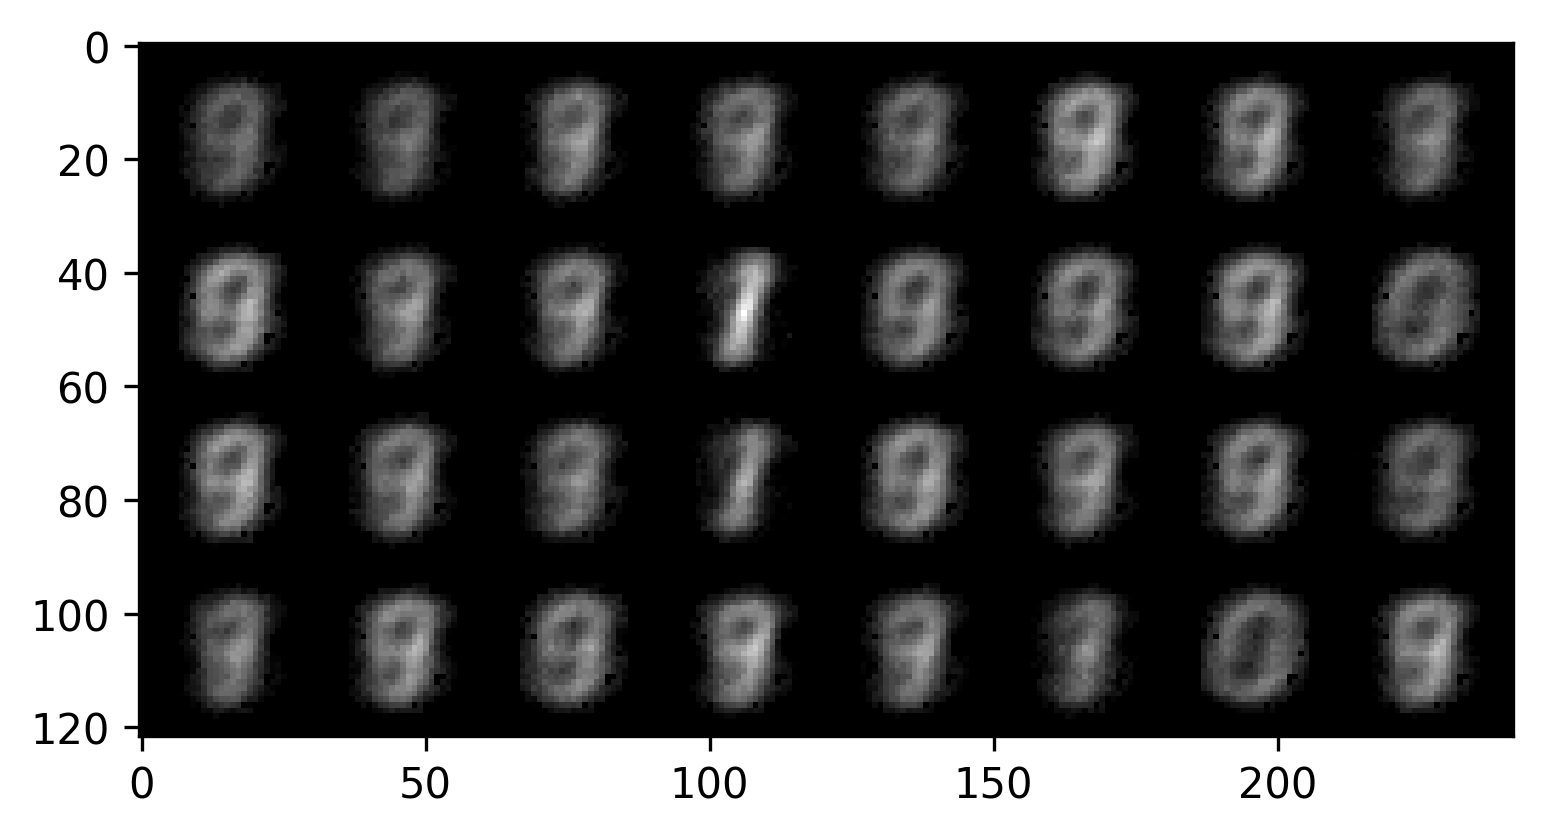

classifier loss:2.79830265045166
classifier loss:0.7840975522994995
tensor([[6]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[9]], device='cuda:0')
te

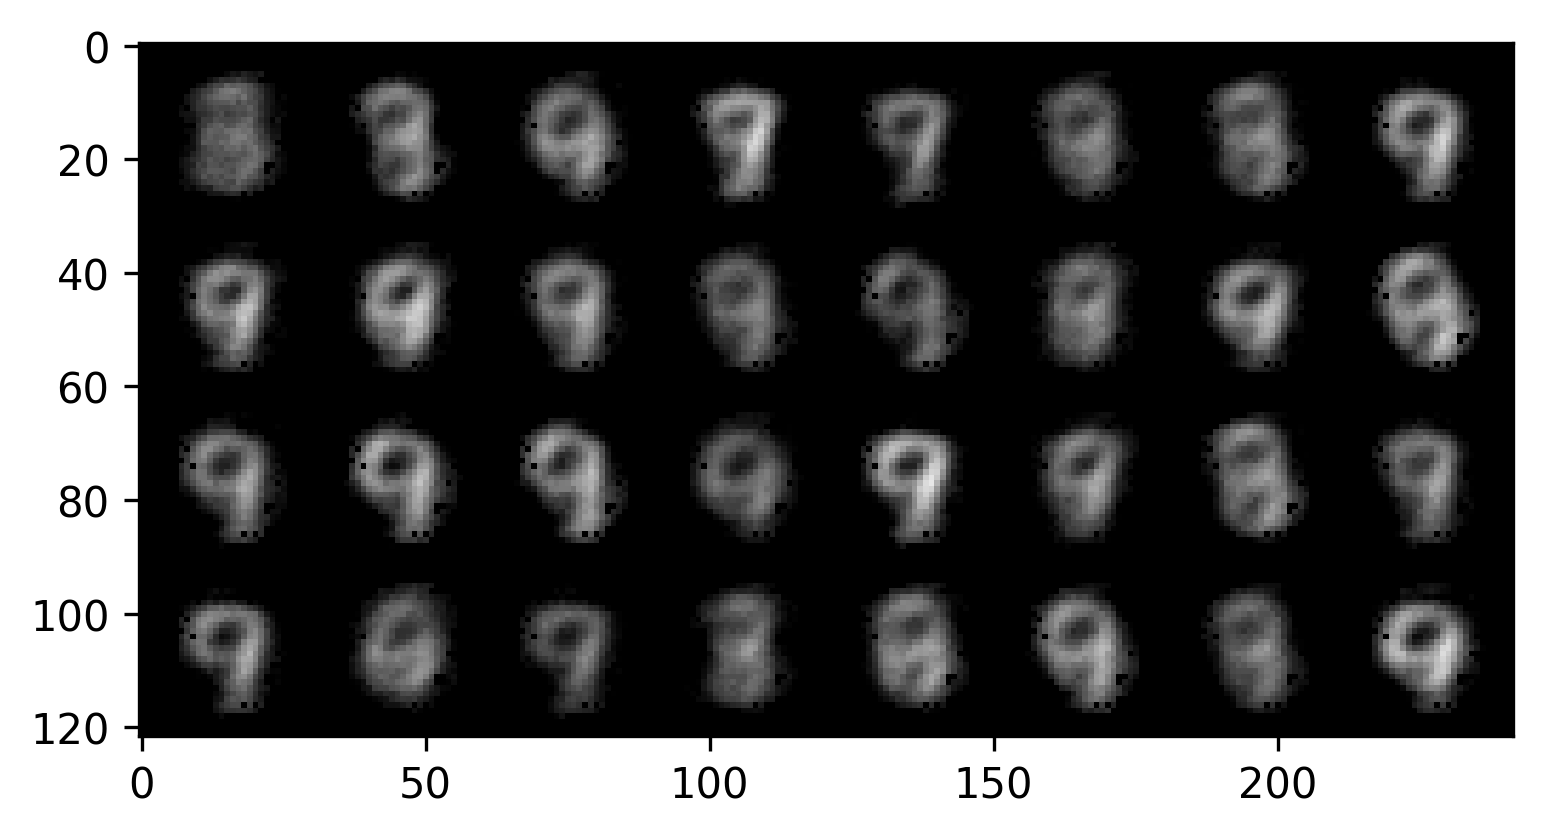

classifier loss:2.2697205543518066
classifier loss:0.8381296396255493
tensor([[8]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[4]], device='cuda:0')


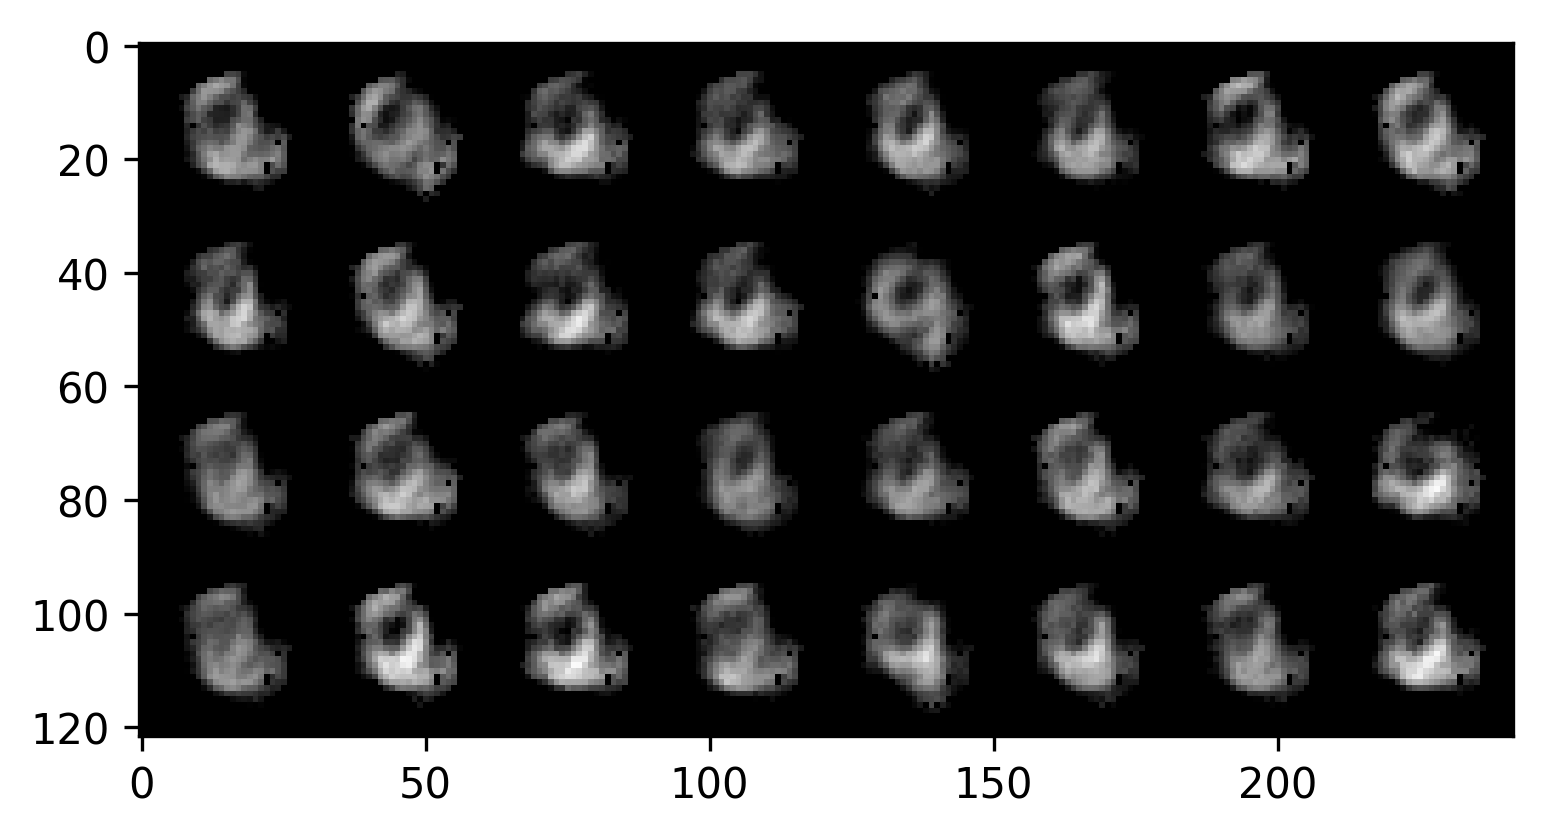

classifier loss:0.7572799324989319


classifier loss:2.8249902725219727
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[3]], device='cuda:0')
tens

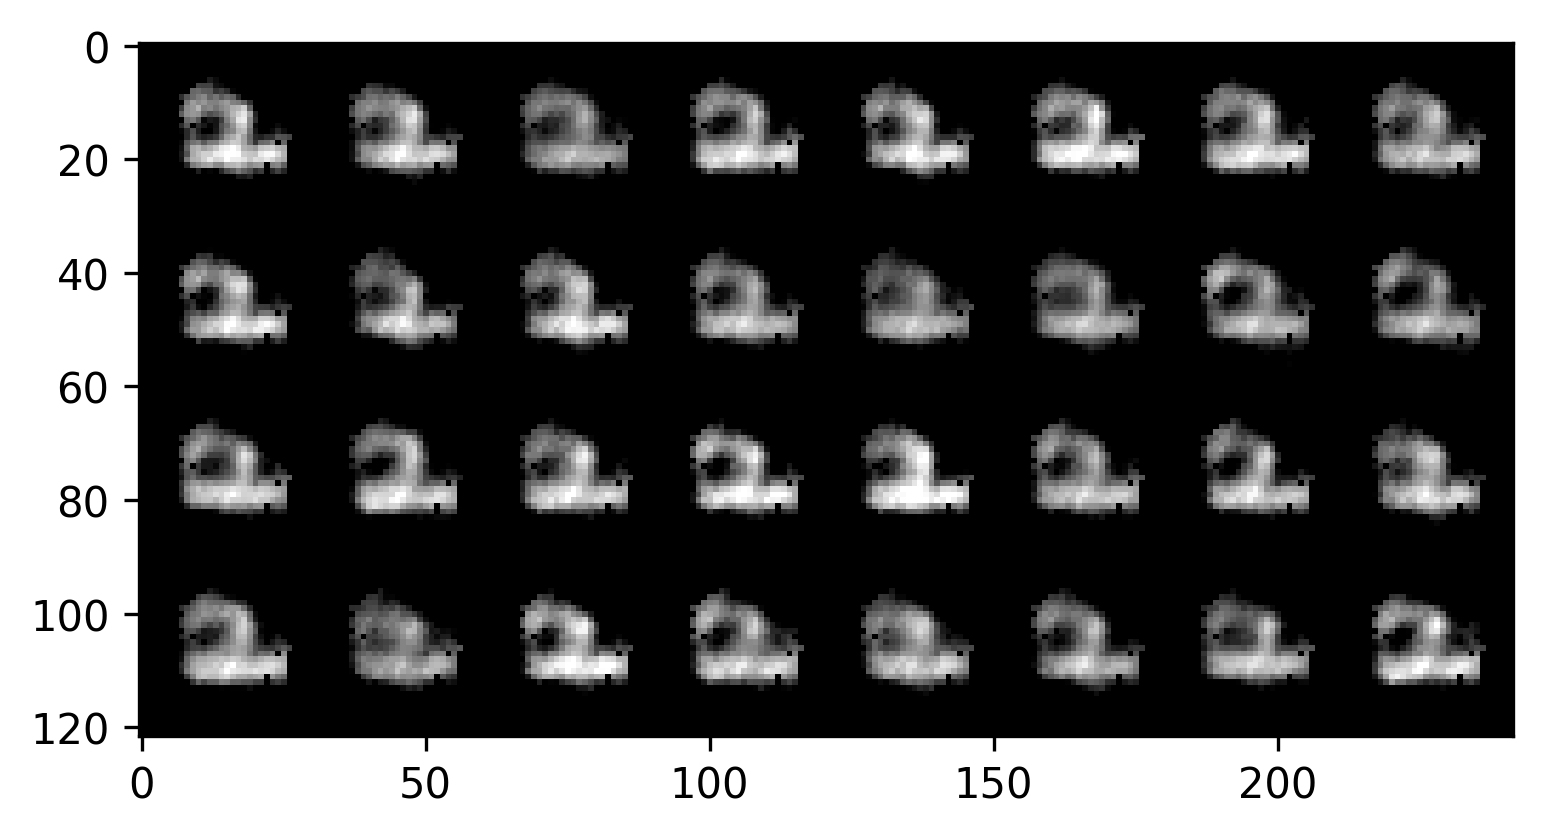

classifier loss:2.854703664779663


classifier loss:2.6470787525177
tensor([[3]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor(

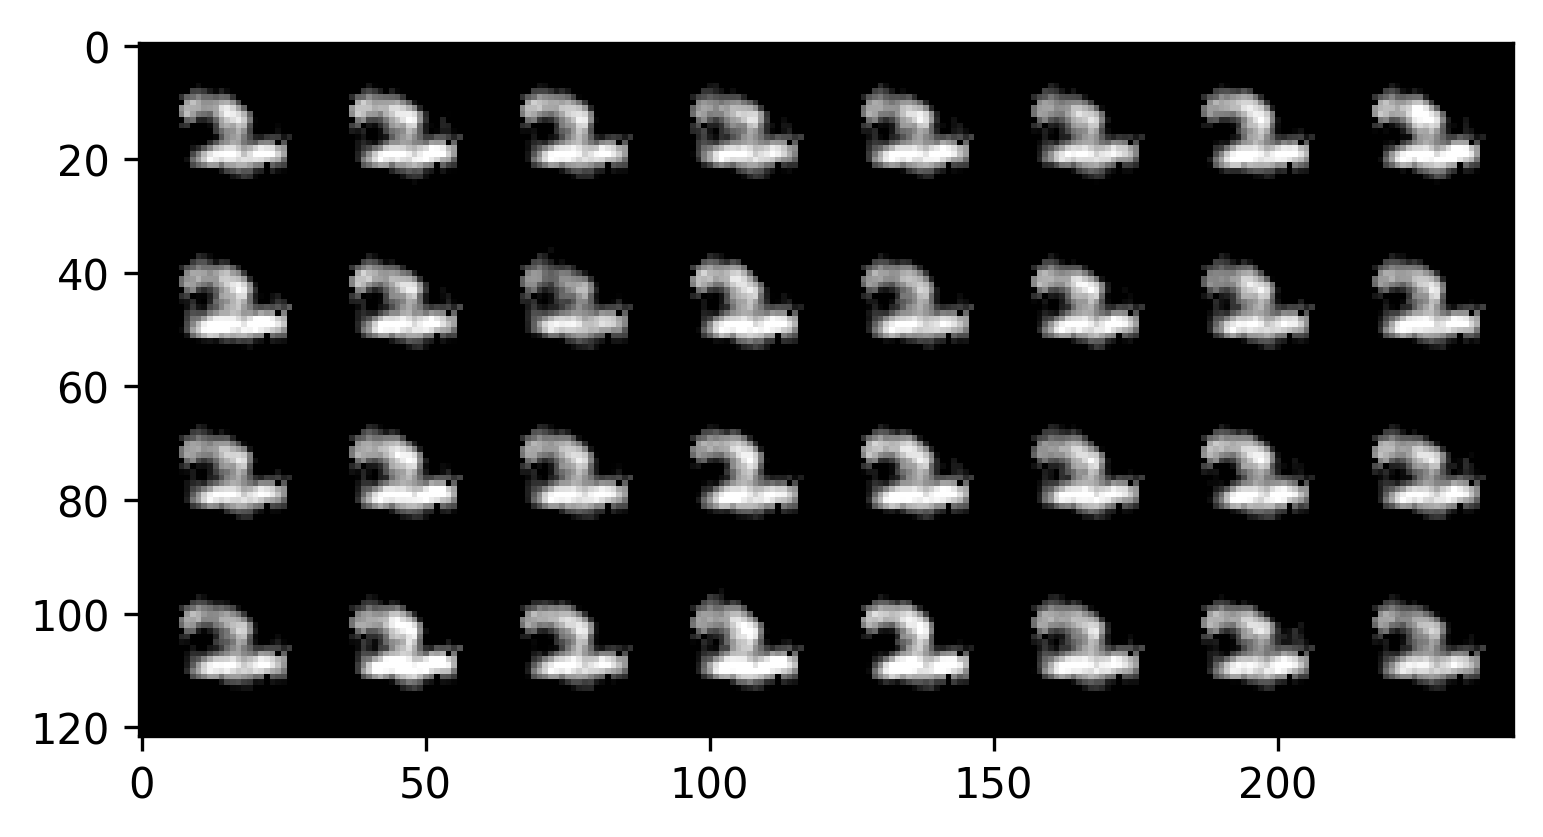

classifier loss:0.7933589220046997


classifier loss:3.0403201580047607
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[1]], device='cuda:0')
tens

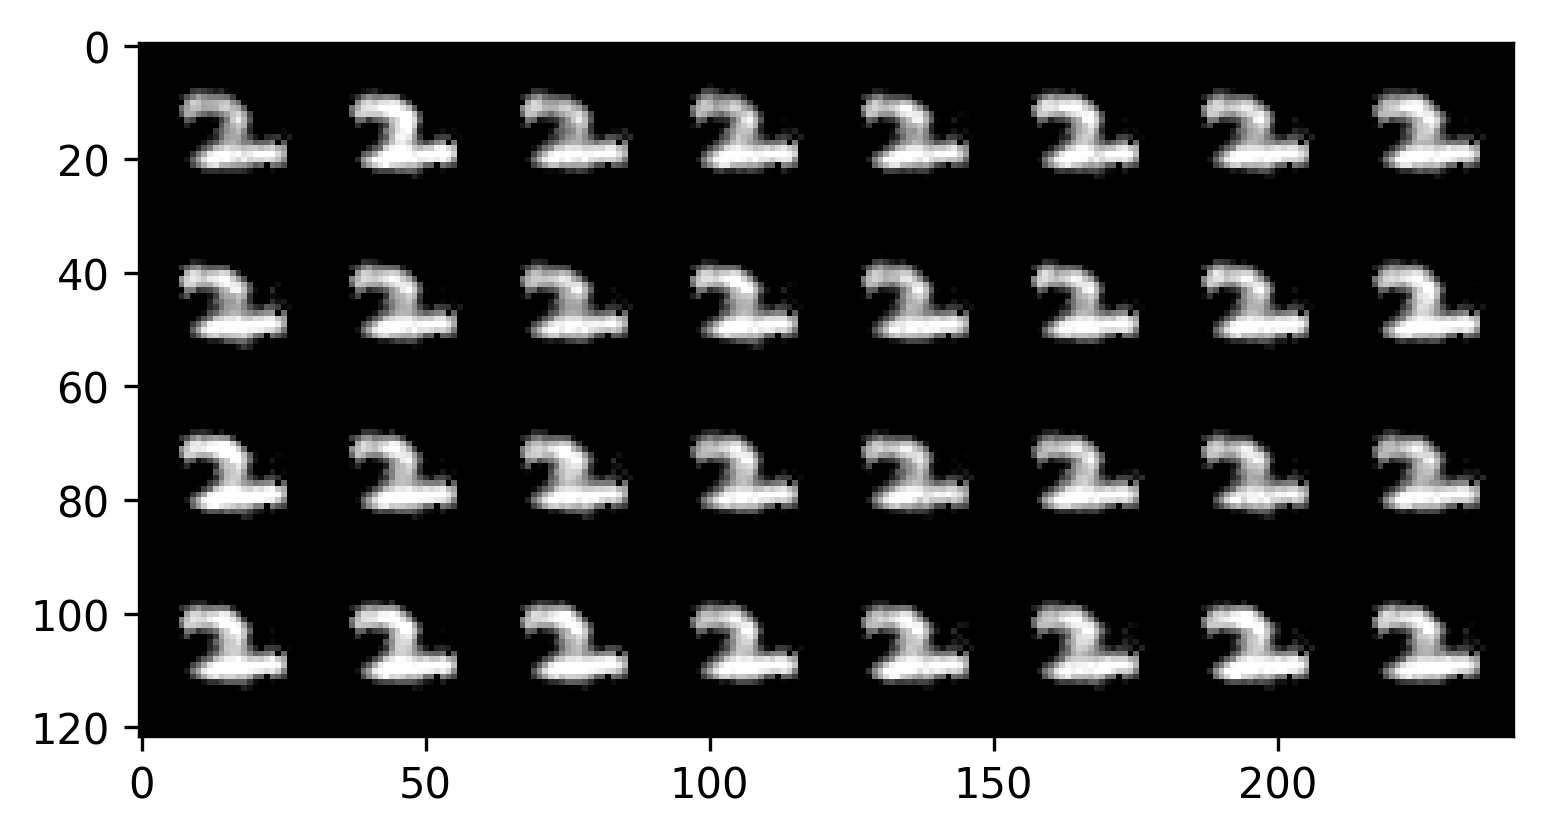

classifier loss:0.8197900056838989


classifier loss:0.7376909852027893
tensor([[1]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[2]], device='cuda:0')
tens

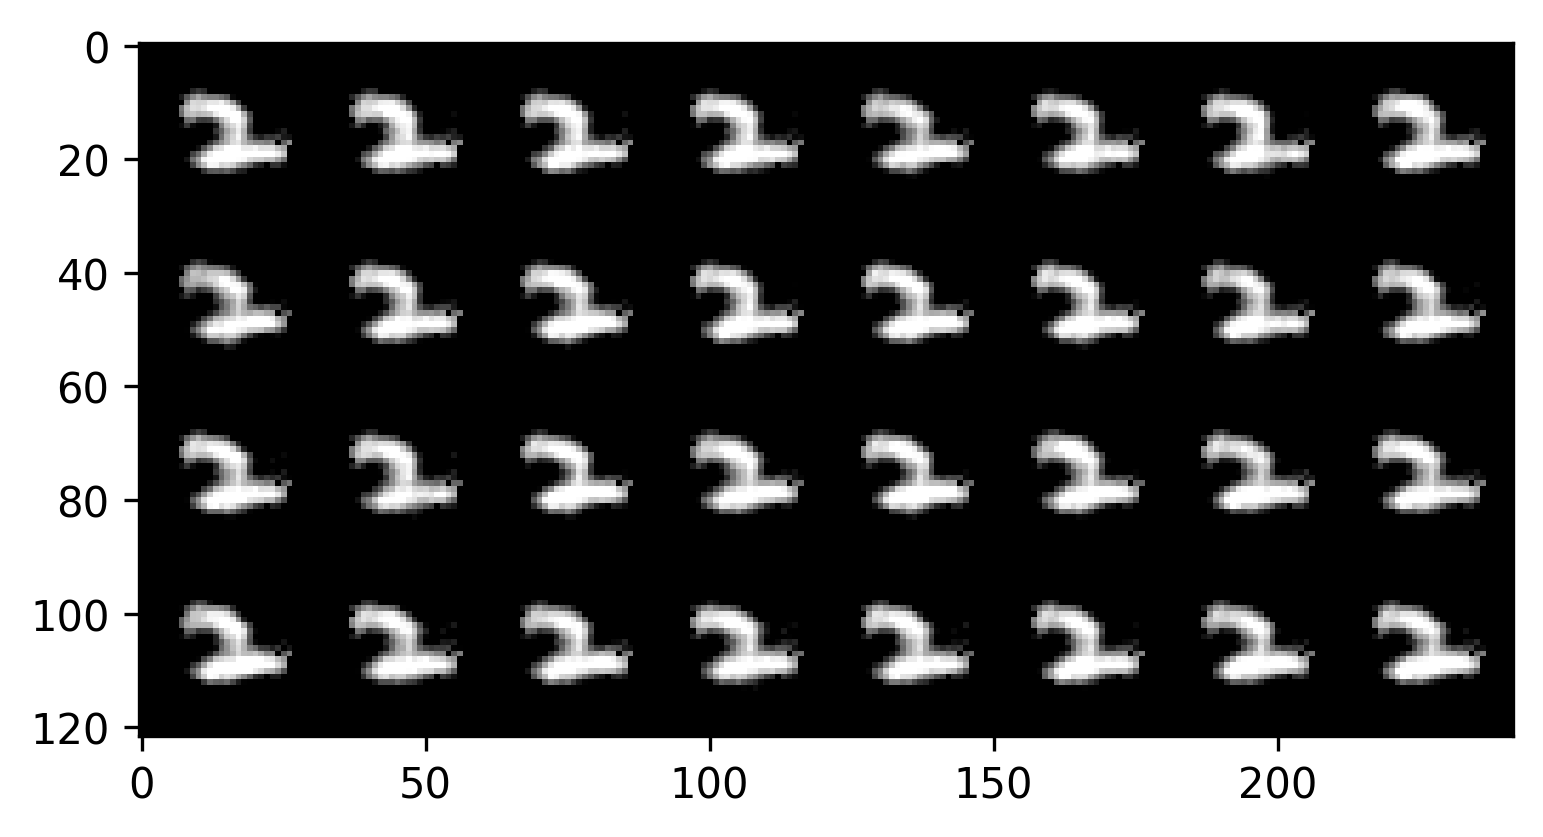

classifier loss:2.925903558731079


classifier loss:0.7267707586288452
tensor([[2]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[4]], device='cuda:0')
tens

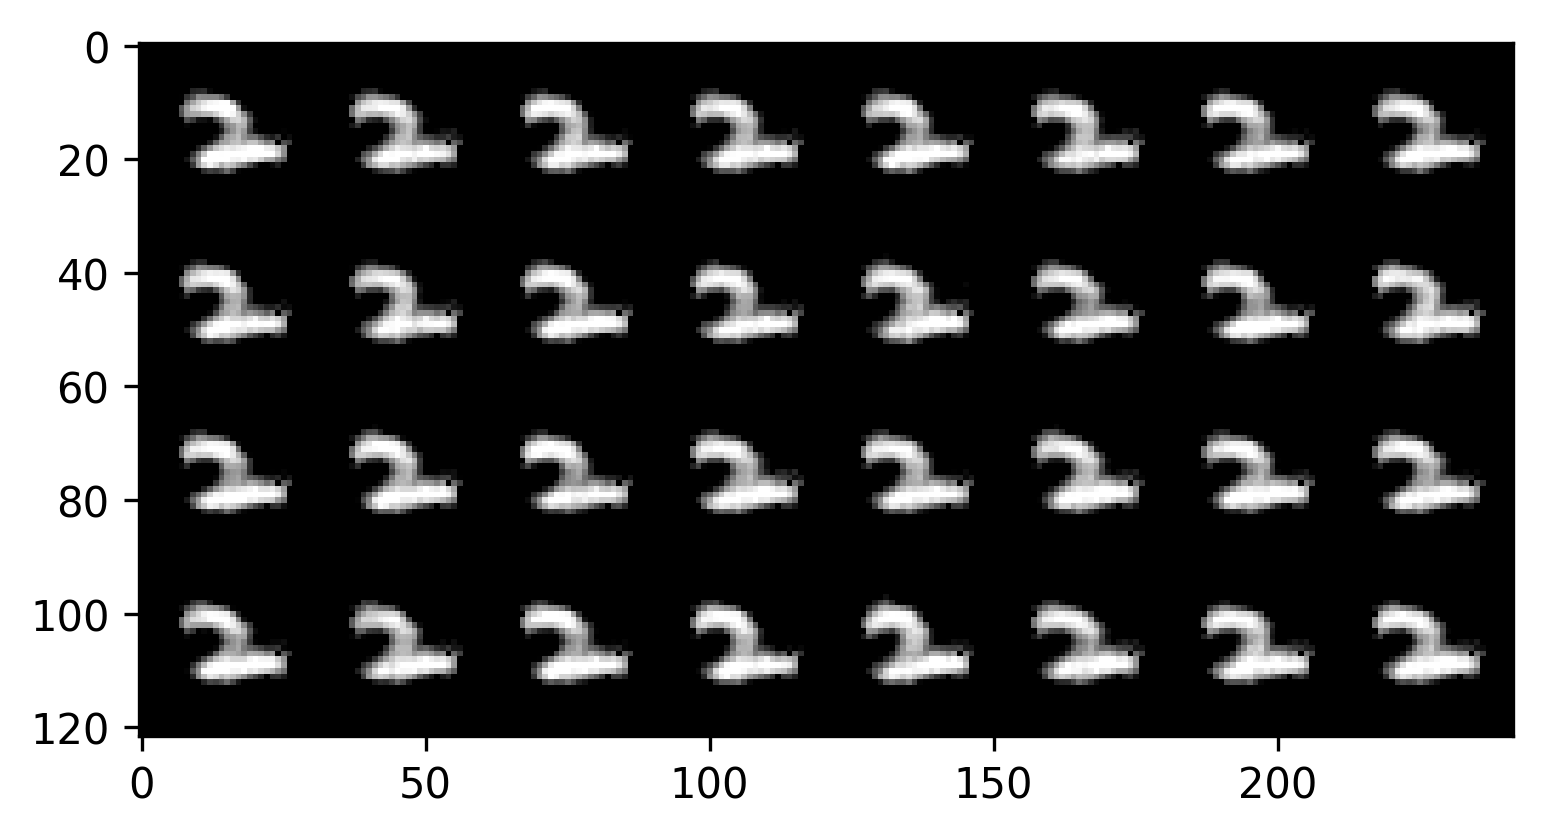

classifier loss:2.898540496826172


classifier loss:0.75738126039505
tensor([[6]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor

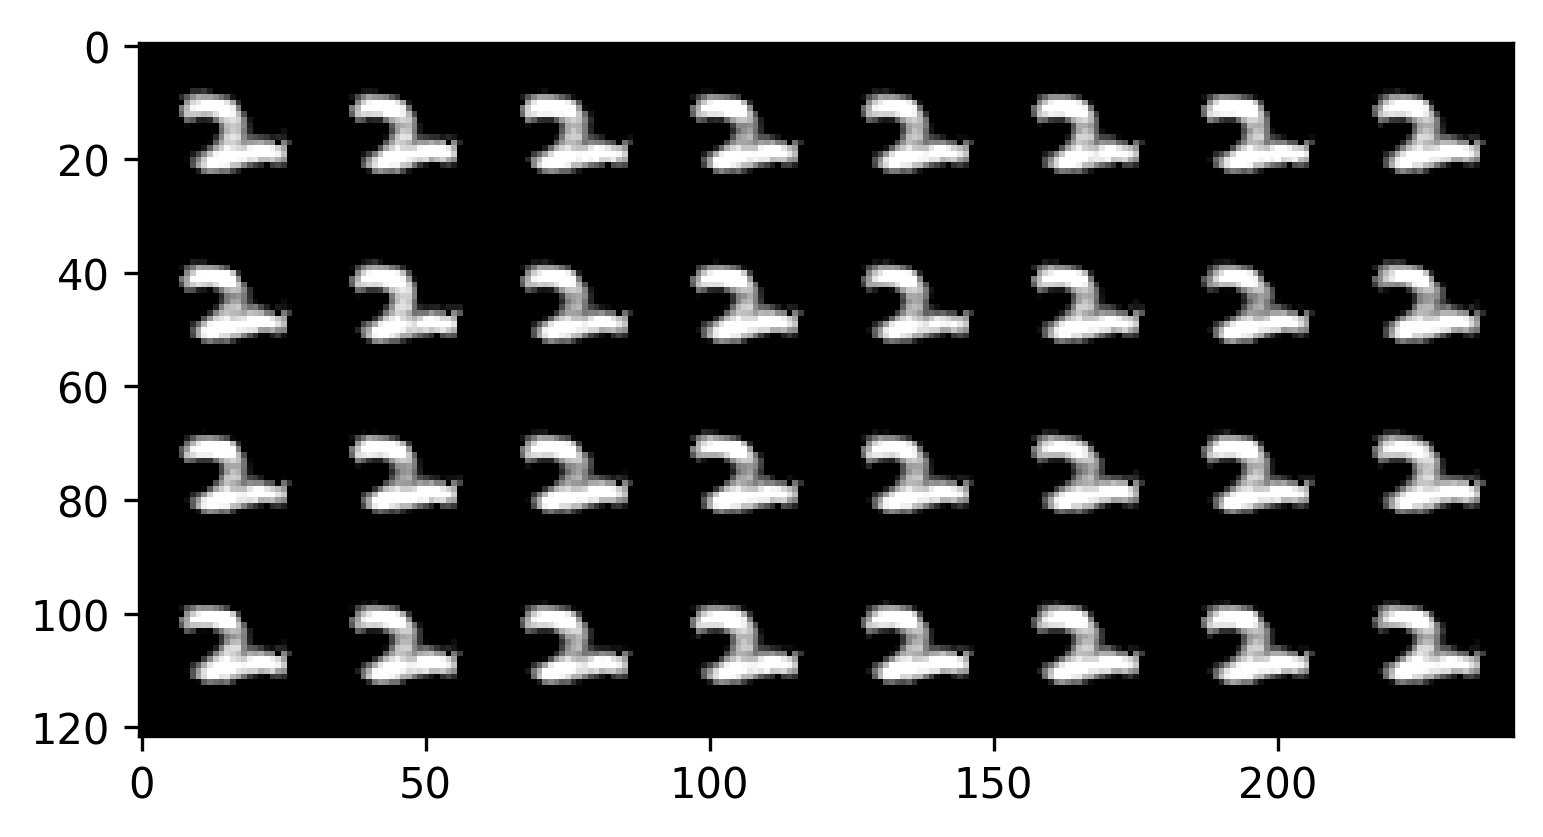

classifier loss:0.8005046248435974


classifier loss:2.7320449352264404
tensor([[7]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[5]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[6]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[4]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[9]], device='cuda:0')
tensor([[7]], device='cuda:0')
tensor([[6]], device='cuda:0')
tens

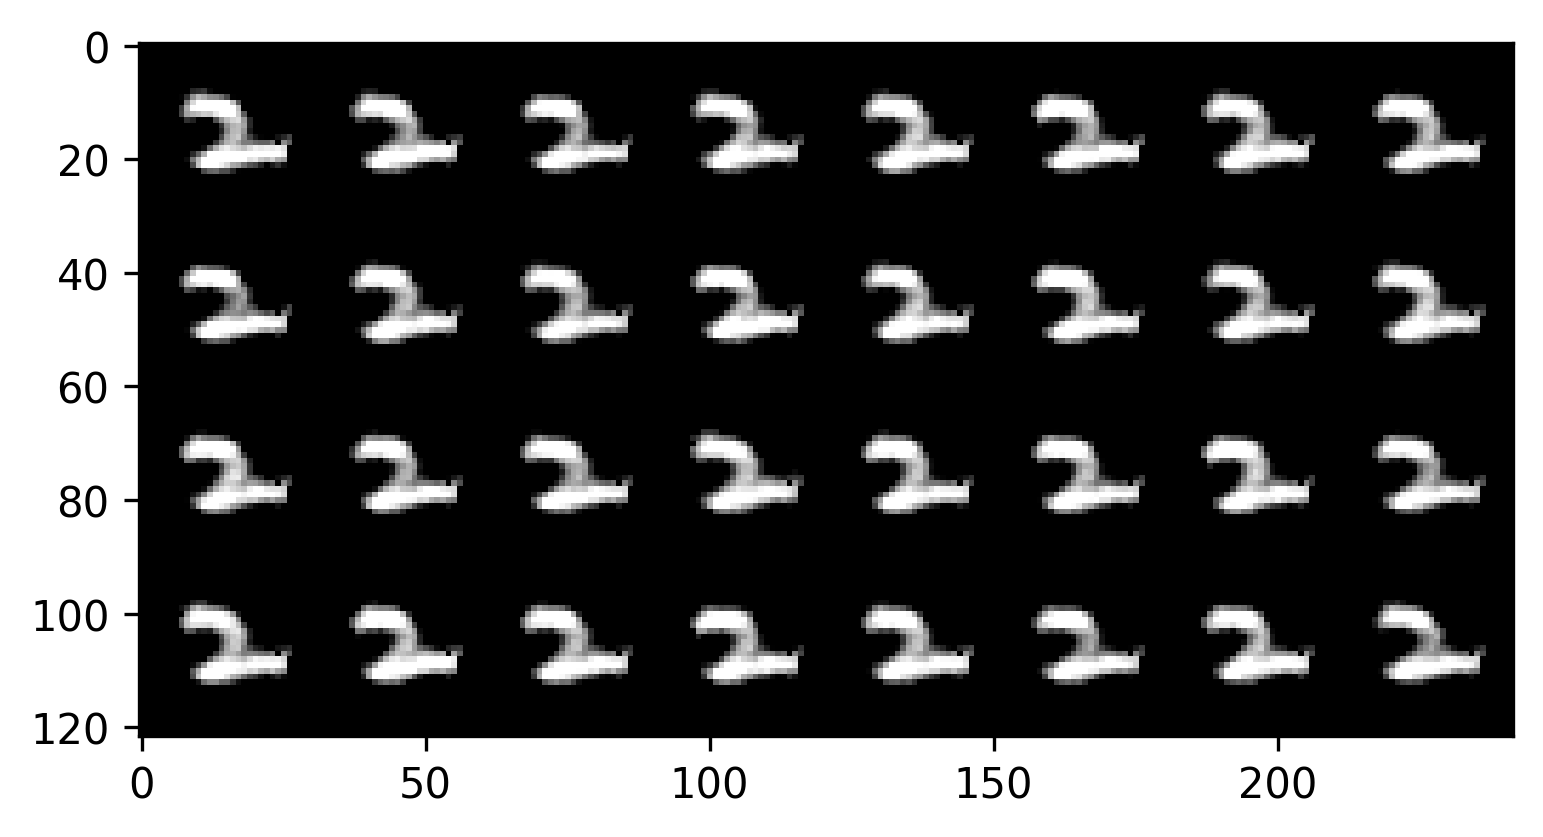

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [19]:
pl.seed_everything(1234)

cond_vae = ConditionalVAE()
trainer = pl.Trainer(gpus=1,
                     max_epochs=20,
                     callbacks=[PeriodicInference(data_module=datamodule)])
trainer.fit(cond_vae, datamodule)

## Plot an image

tensor(3)


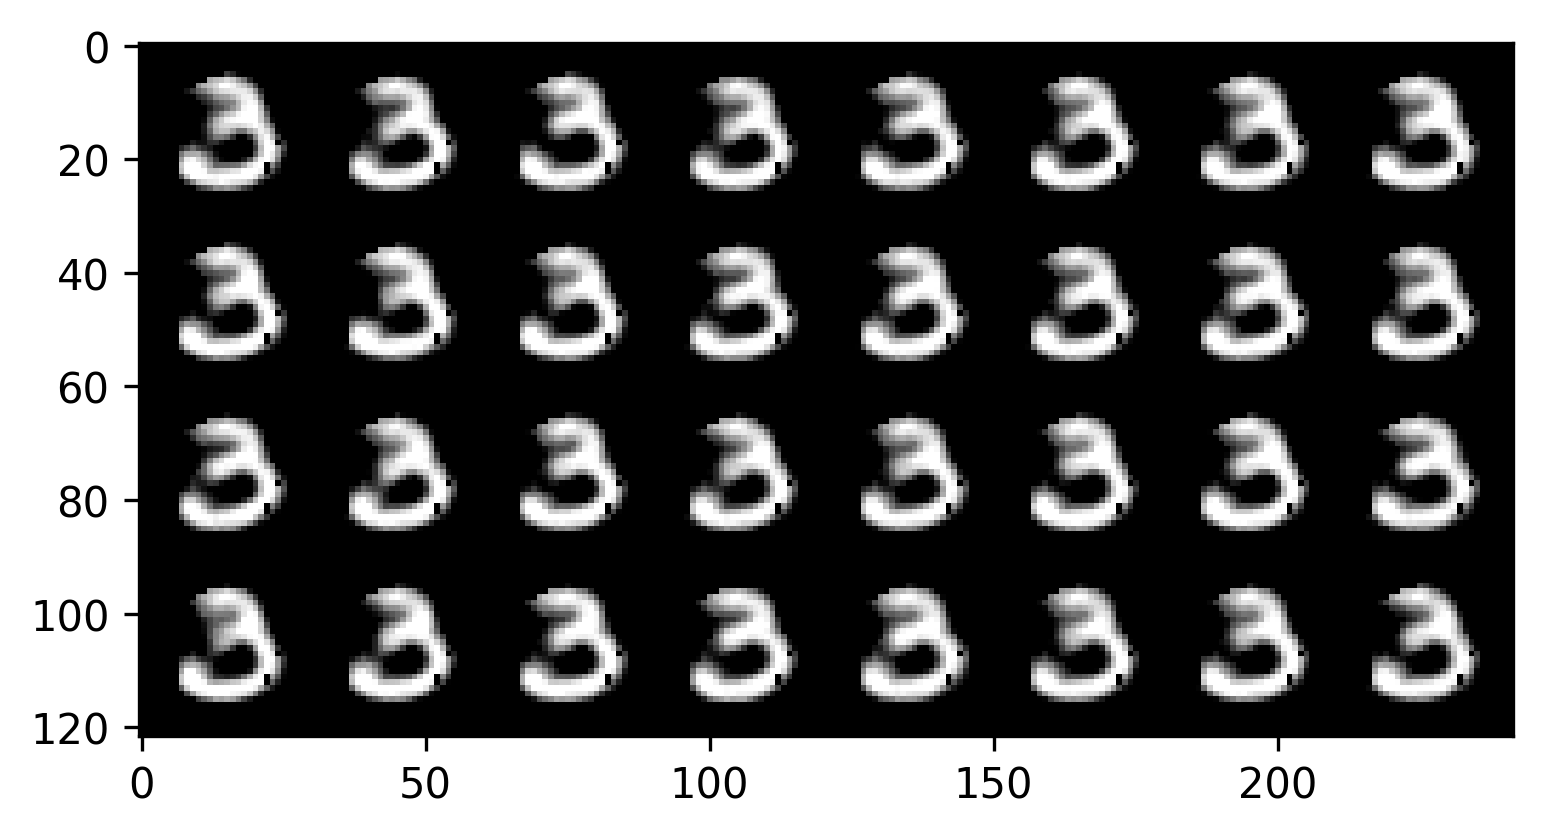

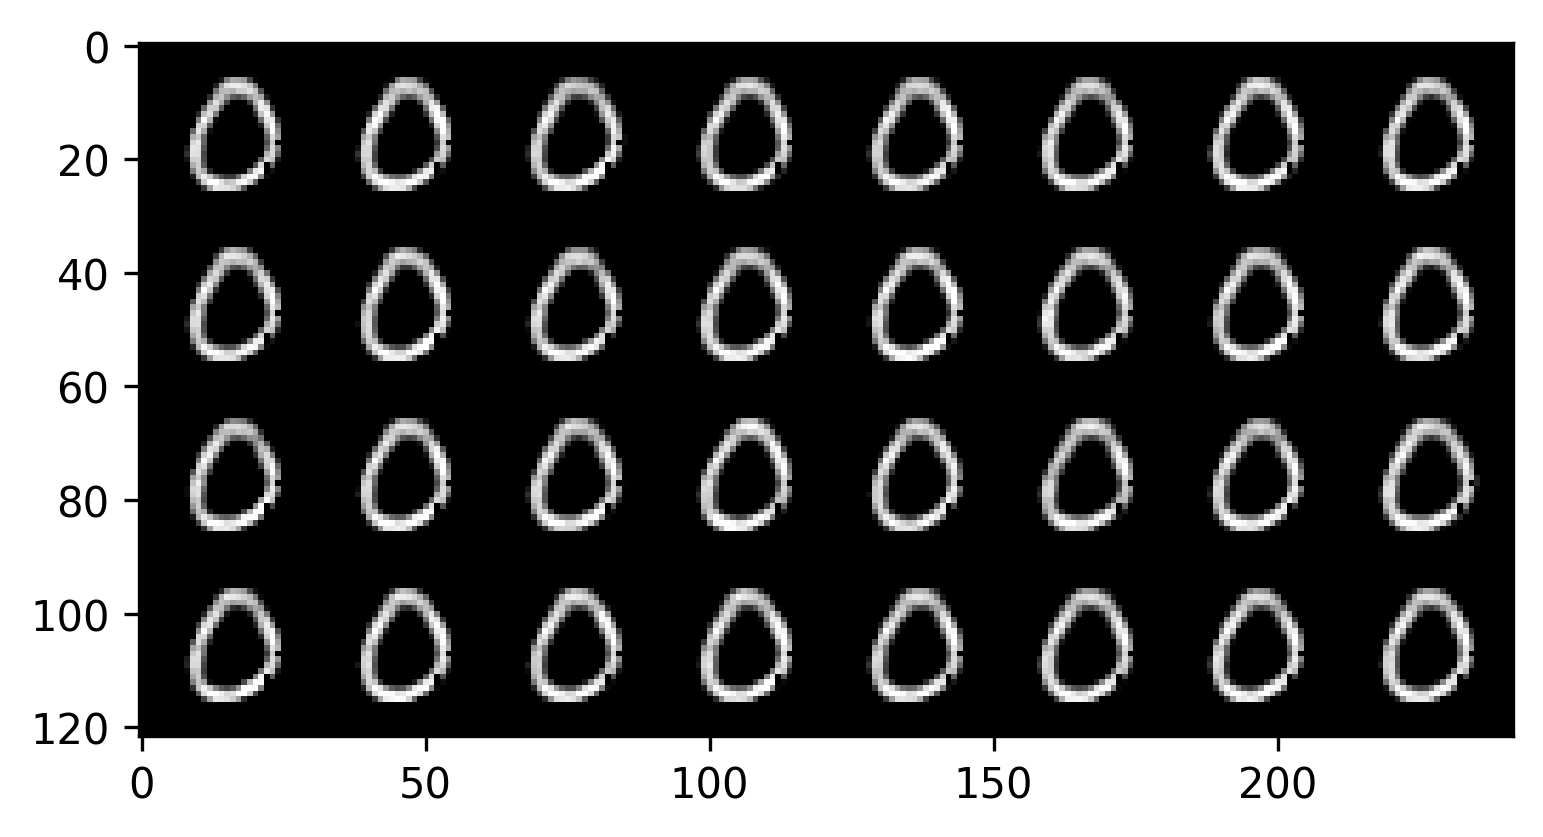

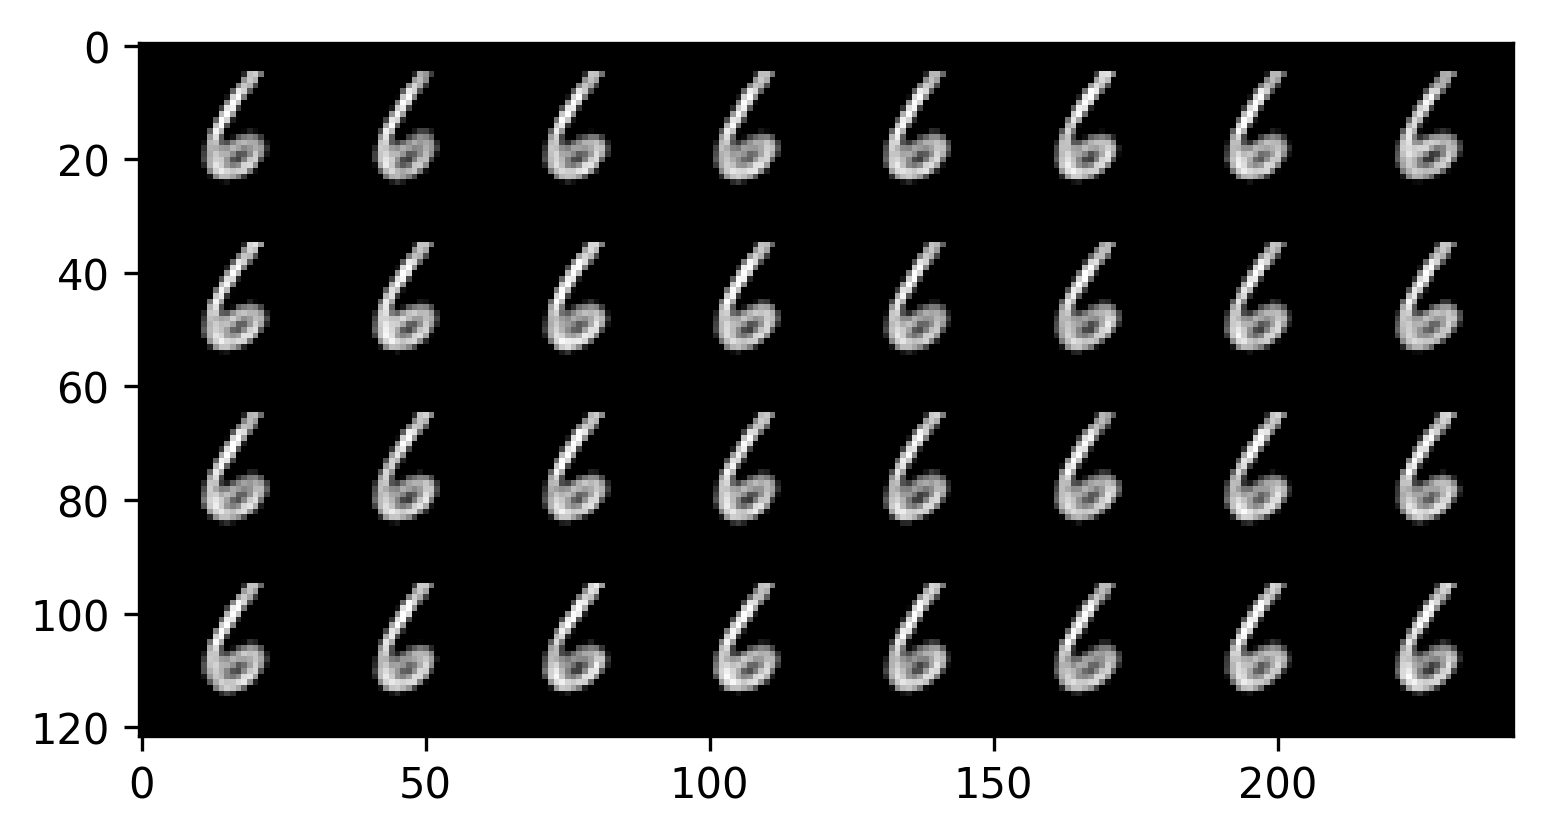

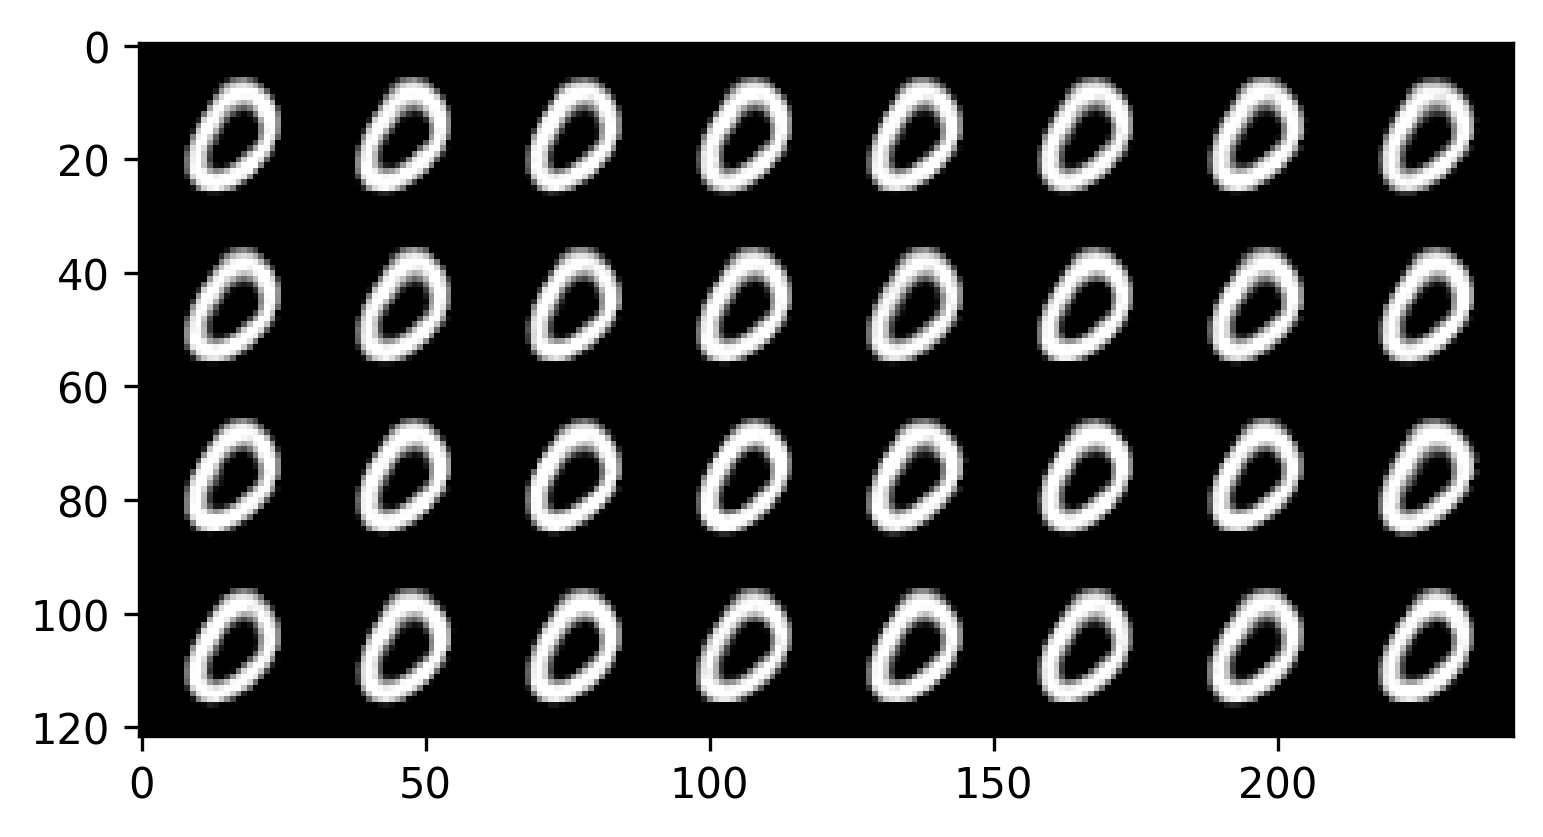

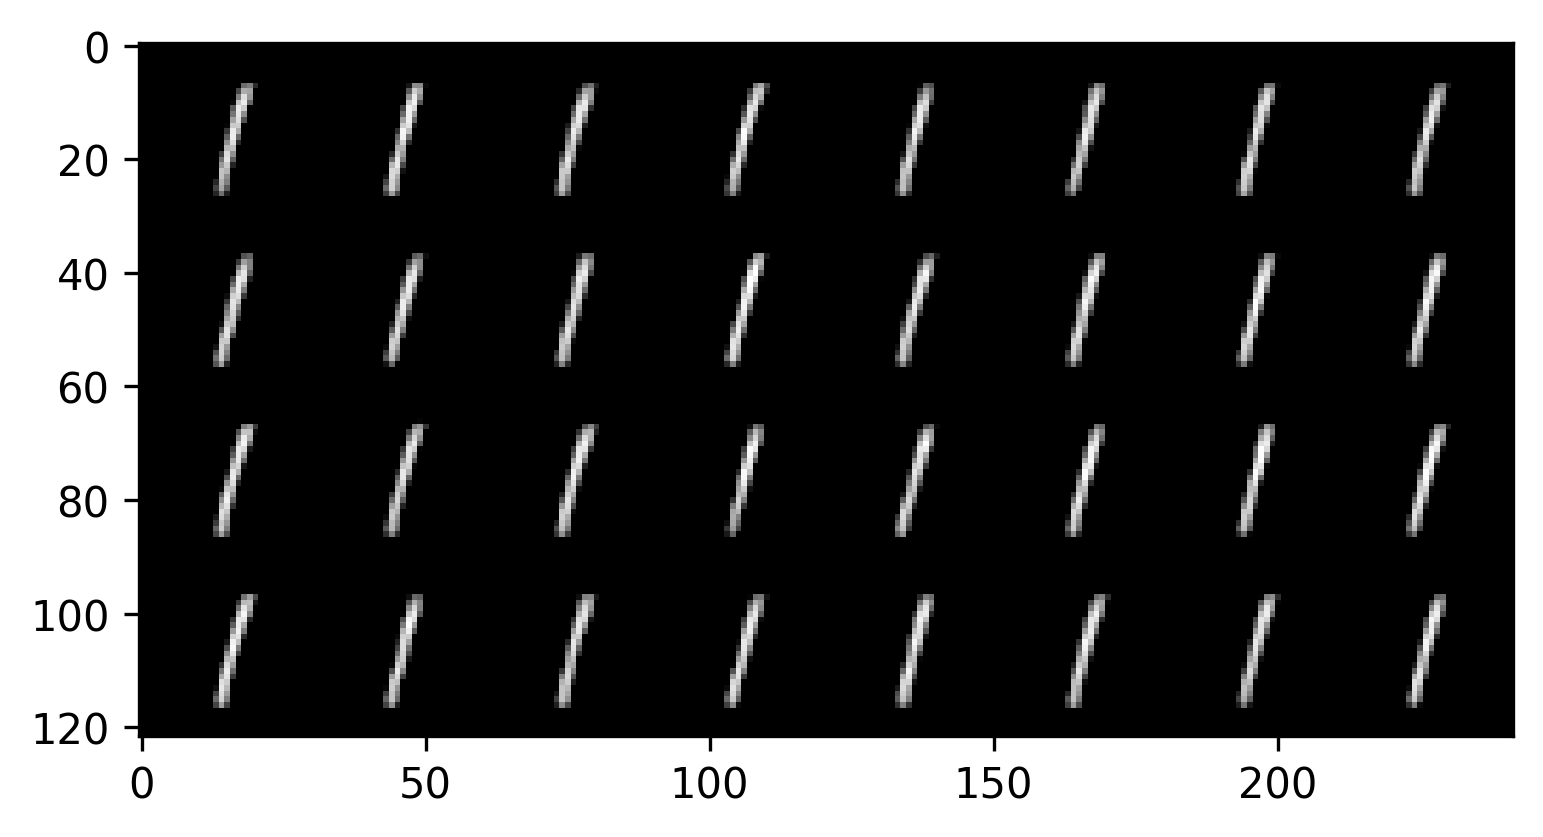

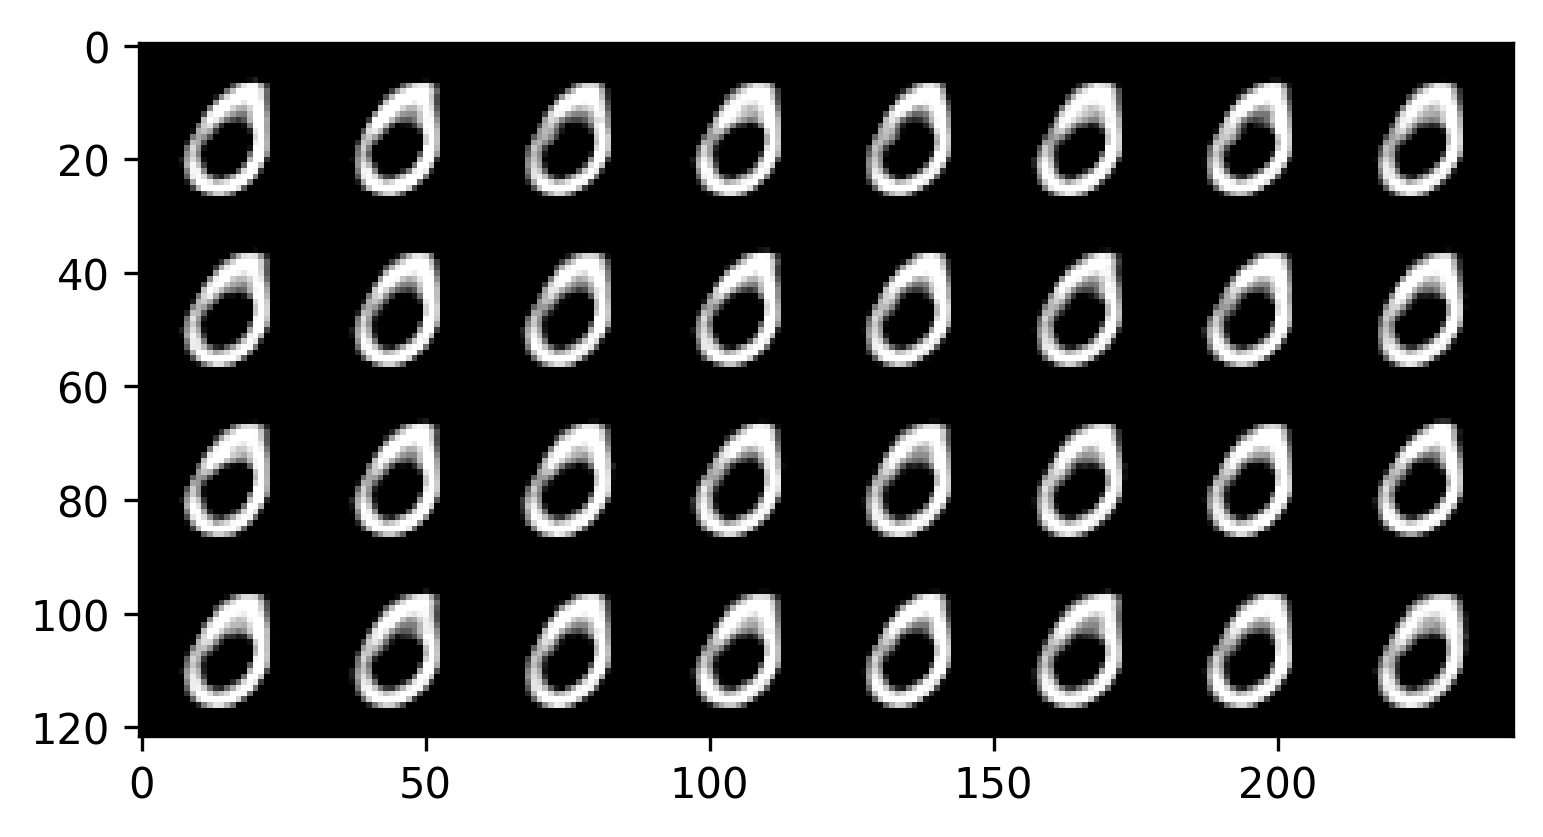

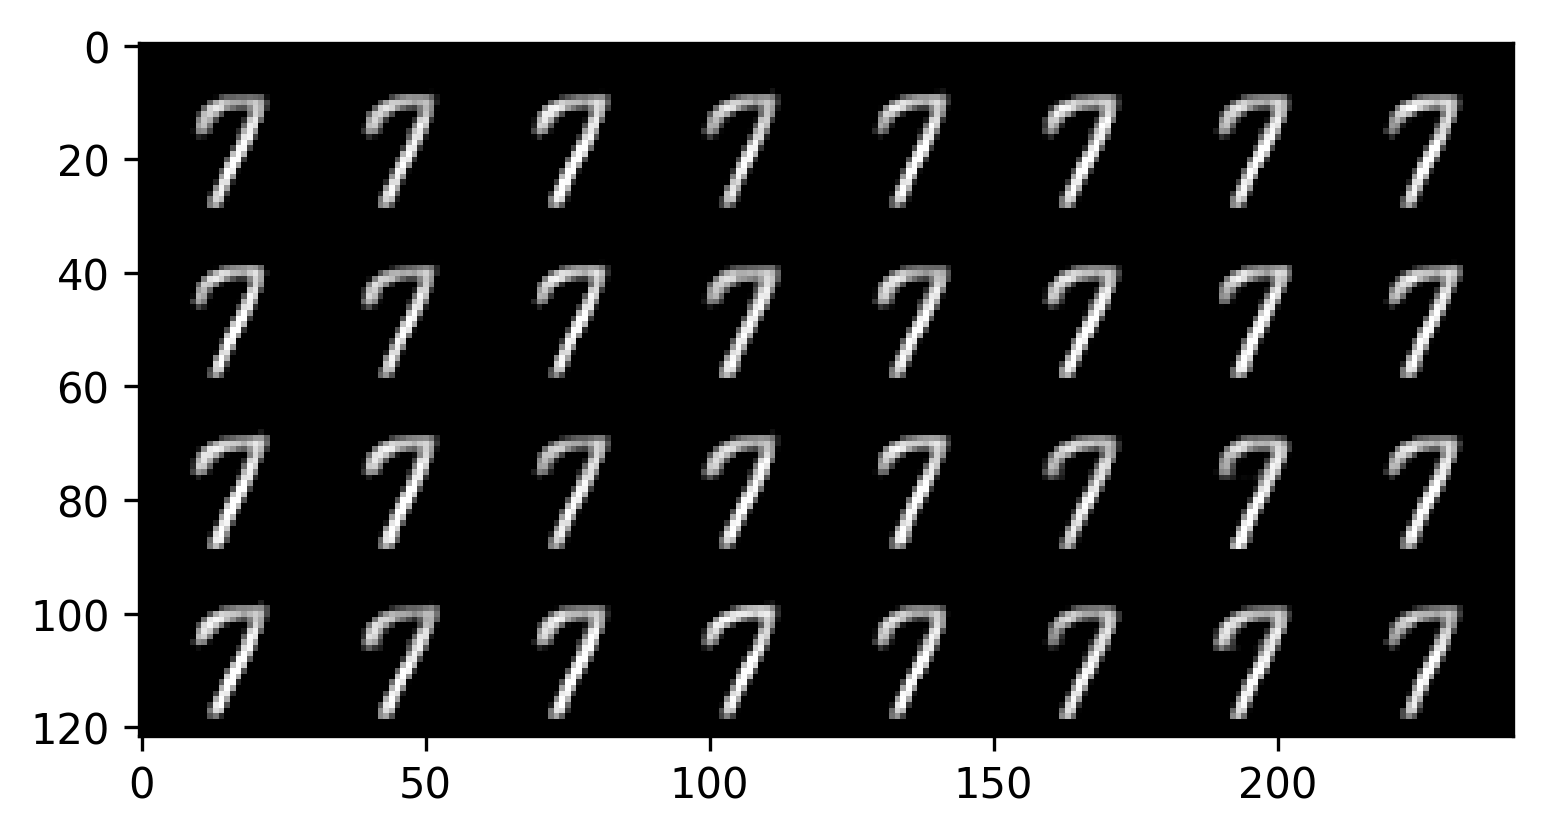

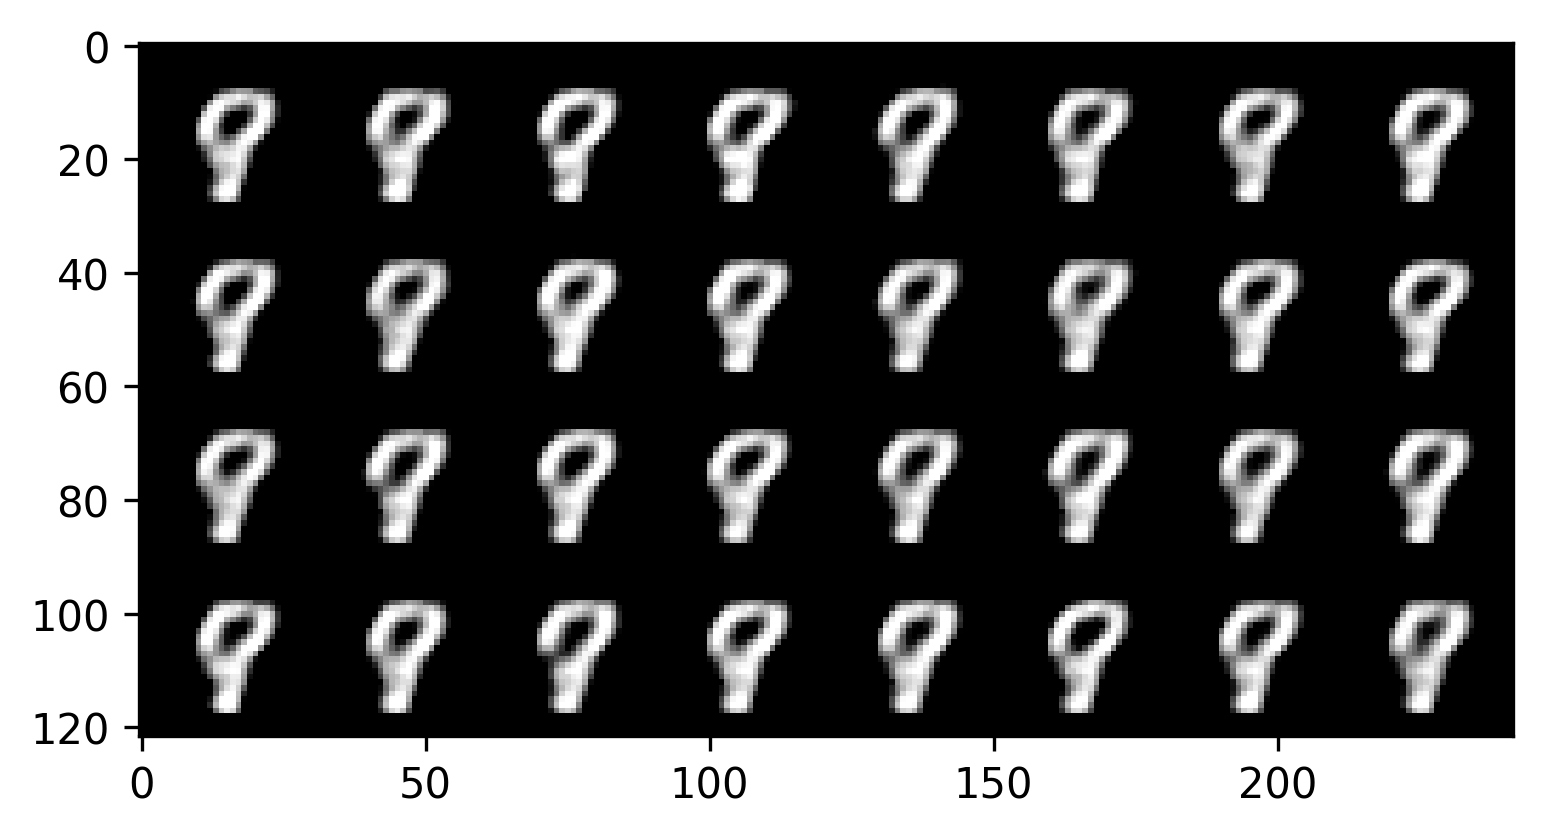

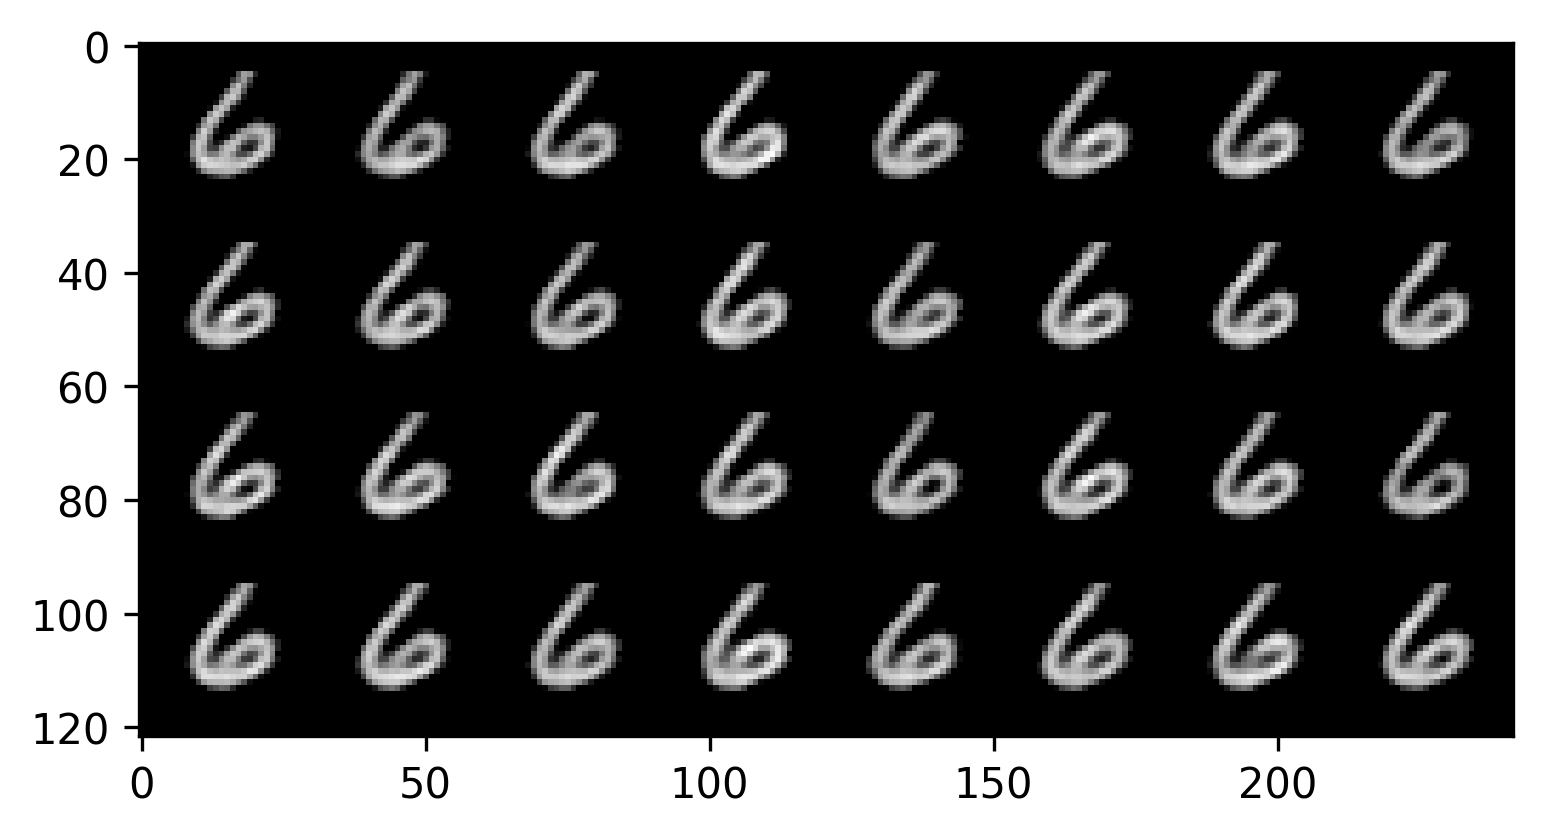

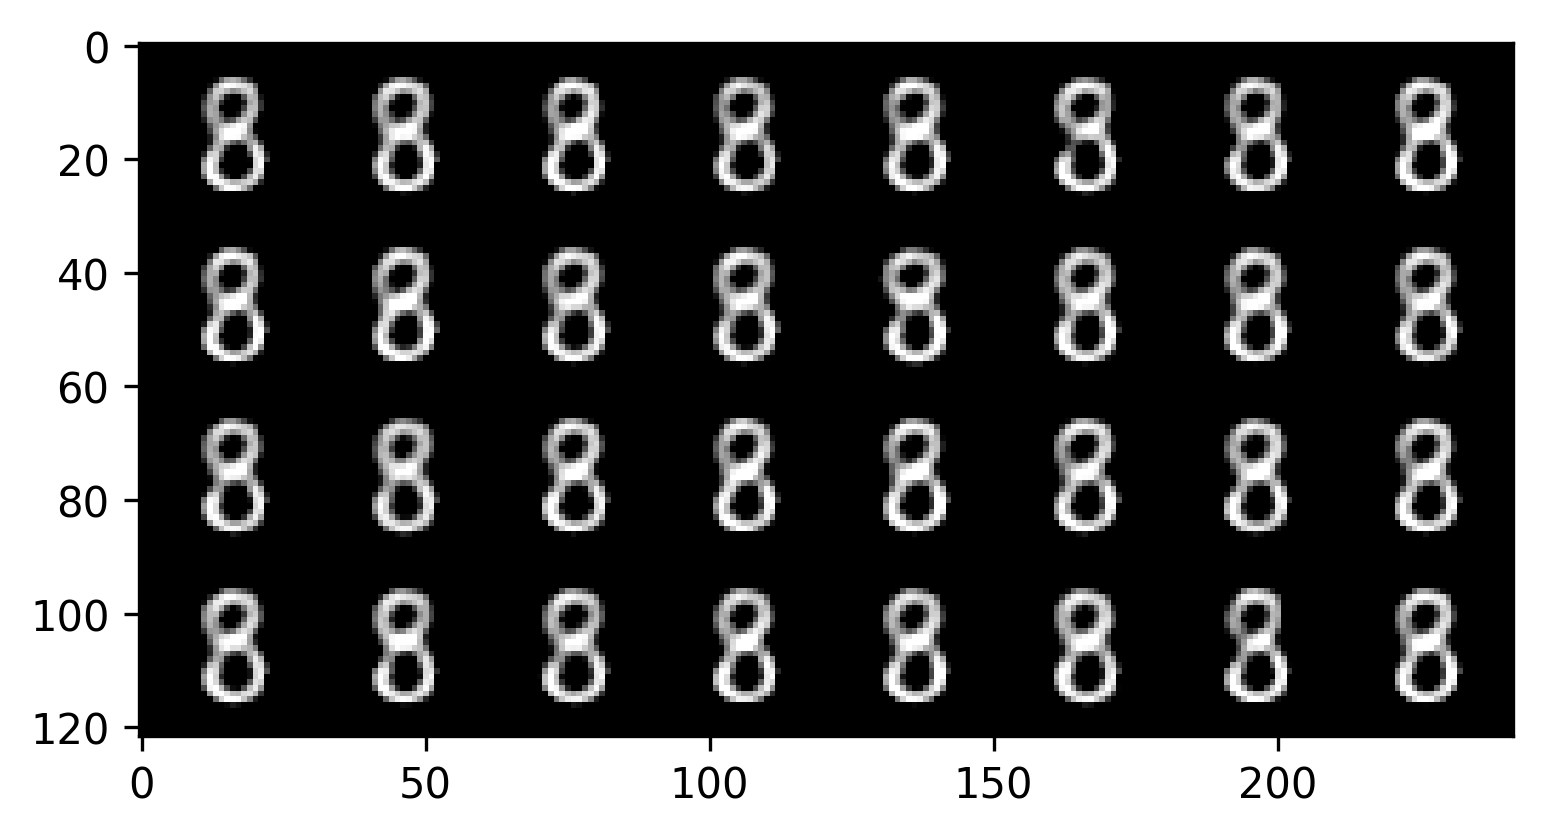

In [26]:
#for _ in range(25):
imgs, labels = next(iter(datamodule.train_dataloader()))
#    generate_images(cond_vae, imgs, torch.arange(), num_images=32)
this_label = labels[0]
print(this_label)
one_label = this_label.unsqueeze(0)
for cnt in range(10):
    one_image = imgs[cnt].unsqueeze(0)
    one_label = torch.tensor([cnt]).unsqueeze(0)
    generate_images(cond_vae, one_image, one_label, cond_vae.device, num_images=32)